# Machine Learning with Signals Problem Set

Per usual, we are going to start by downoloading any packages or data that we need and importing all of the Python packages we will need, too.

In [1]:
# Install Graphvis library if it is not already installed
!pip install graphviz 

# Clone the audio data repository (should cleanly fail if already downloaded)
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# Define the path to where the data are downloaded
data_dir = '/content/free-spoken-digit-dataset/recordings'

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (511/511), done.
remote: Total 3672 (delta 4), reused 510 (delta 4), pack-reused 3157
Receiving objects: 100% (3672/3672), 26.94 MiB | 23.95 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# Import basic system and numerical packages
import os
import re
import numpy as np
import pandas as pd

# Import statistical and signal processing functions
from scipy import signal
import scipy.stats.mstats as mstats
from sklearn import metrics

# Import the scikit-learn functions and models
from sklearn.model_selection import train_test_split
from sklearn import tree

# Import audio i/o and playing functions
import scipy.io.wavfile
from IPython.display import Audio

# Import plotting functionality
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

# Setup the plotting preferencs
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Problem 1:
$\text{Ben Bitdiddle}$, an amateur data scientist, is working on a difficult classication problem given by his boss $\text{Alyssa P. Hacker}$. Eventually, he comes up with a few features that be beleives are best of the best for his data and plots them below. Based on the visualization in the plot below, which feature is the most useful and which one is the least useful, why? Is Ben really the best?

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week2/good_or_bad_features.png">


X2 is the most useful becaus it has the least correlation with the other features. X3 is the least useful because there is only one plot and they are quite correlated. Ben generated a weird pair plot matrix so he is not the best.

##Problem 2

  Here we are revisiting our dataset of recordings of spoken digtis (0-9). Here we will add some twists! Remember to visualize and really think about what features may or may not be useful!

In [3]:
# Let's double check that get got all of the files we expected
file_list = os.listdir(data_dir)
print('{} audio samples\n'.format(len(file_list)))

# list the first few files
print('Example files...')
print(file_list[0:10])

2500 audio samples

Example files...
['4_nicolas_25.wav', '4_yweweler_35.wav', '6_yweweler_6.wav', '9_jackson_31.wav', '5_theo_28.wav', '9_theo_0.wav', '6_jackson_49.wav', '4_theo_46.wav', '4_nicolas_45.wav', '0_yweweler_44.wav']


## Feature Engineering
As we saw earlier, some features are more useful for classification than others. Here, we provide you with functions to extract the "spectral centroid" and "spectral flatness" features from an audio file, but we will also help you start to build your own feature extracting functions.

### Spectral Centroid

The [**spectral centroid**](https://en.wikipedia.org/wiki/Spectral_centroid) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:
$$f_c=\frac{\sum_kA(k)f(k)}{\sum_kA(k)}$$
 
where $A(k)$ is the spectral magnitude at frequency bin $k$,  $f(k)$ is the frequency at bin $k$
 .

In [4]:
def spectral_centroid(ft, f_s):
    """
    Computes the spectral centroid from the FT of a signal

    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    :param f_s: sampling frequency (or `sampling rate`) (in Hz)
    """
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    # Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples//2]
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)
    
    # Compute the weighted frequency to get the specral centroid
    spec_centroid = np.sum(magnitude*freqs)/np.sum(magnitude)

    return spec_centroid

### Spectral Flatness

The [**spectral flatness**](https://en.wikipedia.org/wiki/Spectral_flatness), also known as Wiener entropy, is a measure used in digital signal processing to characterize an audio spectrum. Spectral flatness is typically measured in decibels, and provides a way to quantify how noise-like a sound is, as opposed to being tone-like.

In [5]:
def spectral_flatness(ft):
    """
    Computes the spectral flatness of the FT of a signal
    
    :param ft: output of Fourier Transform (i.e., np.fft.fft())
    """
    # Grab the magnitude of the relevant part of the fourier transform values
    num_samples = len(ft)
    magnitude = abs(ft[0:num_samples//2]) * (2/num_samples)
 
    # Spectral flatness is simply the geometric mean of the FT magnitude
    # divided by the arithmetic mean of the FT magnitude
    spec_flatness = mstats.gmean(magnitude)/np.mean(magnitude)

    return spec_flatness

### Spectral Roll-off
In this section, you are going to write the code to extract a new feature called "spectral roll-off". This measure can used to measure the distinguish voice from non-voice audio. This can be used to give a good idea of what frequencies contain the majority of the energy. Spectral roll-off cam be computed from the inequality:

$$\sum^{r}_{k=0} A(k) \geq 0.85\sum^{N}_{k=0} A(k) \text{,}$$

where $A(k)$ is the magnitude of the fourier transform at index $k$.

The idea is to find the frequency associated with index $r$, where the sum to the magnitudes in the fourier transform from $k=0$ up to $k=r$ is greater than or equal to $85%$ of the sum the magnitudes from $k=0$ to $k=N$.

In [21]:
def spectral_rolloff(ft, f_s):
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)# <-- UPDATE THESE LINES
    freqs = np.linspace(0, f_s, num_samples)       # <--

    # Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples // 2]       # <-- UPDATE THESE LINES
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)   # <--

    # Compute the sum of *all* the fourier transform magnitudes
    whole_sum = np.sum(magnitude)   # <-- UPDATE THIS LINE

    # Initialize a variable to hold the cumulative sum of the magnitudes of the
    # fourier transform as we loop over it.
    cumulative_sum = 0.0

    # Loop over each element in the fourier transform
    for k, ft_mag in enumerate(magnitude):
        # Add the current magnitude of the cumulative sum
        cumulative_sum += ft_mag     # <-- UPDATE THIS LINE

        # Check if the cumulative sum is currently greater than 85% of the
        # whole sum, and return the frequency at which this inequality first
        # becomes true.
        if cumulative_sum >= 0.85*whole_sum:
            return freqs[k]

#Implement your own feature extractors
Add your own feature! We've added some common techniques based on some popular audio signal processing methods. However, there are plenty out there. The links below contain some information regarding a few possible features to use (including some we have already implemented).

Sourc 1: https://musicinformationretrieval.com/spectral_features.html

Source 2: https://www.cs.ccu.edu.tw/~wtchu/courses/2014f_MCA/Lectures/Lecture%209%20Audio%20and%20Music%20Analysis%202.pdf

There are lots of features to choose from, so pick a few that you think mightc help classify an audio clip (or feel free to create your own ;-) ). 

A few possible features from these sources:
* Spectral Bandwidth
* Spectral Flux
* Zero Crossing Rate
* Spectral Contrast
  - This one is tricky because it requires using some form of the "spectrogram" (not just the fourier transform), but it also contains *much* more information and may be helpful for signal classification.

Other ideas:
* The "Maximum Frequency Value" shown in the tutorial stil exists. We are not using it here, but don't forget it exists.
* Weighted standard deviation of the fourier transform
   - This would be analogous to the spectral centroid but for standard deviation
* Break up frequency into several "frequency subbands", compute centroid within each subband, and use each of those centroid values as a feature
* Use the *number* of different peaks in the fourier transform as a feature
* The sky is the limit, so get creative!


In [22]:
def feature1_extractor(ft, f_s):
    """The cool feature extractor I wrote"""
    #Spectral Flux

    #generate frequencies associated with fourier transform values
    num_samples = len(ft)

    # grab magnitude of fourier values
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)
    
    deltas = np.diff(magnitude, 1)
    return np.sum(deltas ** 2)

In [27]:
def feature2_extractor(y, f_s):
    """The even cooler feature extractor I wrote
    X: time-domain signal"""
    #Zero Crossing Rate
  
    #Convert time signals to 0 for negative or 1 for positive
    signs = np.zeros(len(y))
    for i in range(len(y)):
      if y[i] > 0:
        signs[i] = 1
      else:
        signs[i] = 0
    
    deltas = np.abs(np.diff(signs, 1))
    return .5 * np.sum(deltas)

## Load full dataset and extract features

In [37]:
# We can use the regular expression functionality (`re` package) to robustly
# parse the name of each audio file to retrieve the digit spoken, the person
# speaking, and the trial number of that digit-speaker pair.
#
# The following lines create little "string parsers" to grab that information.
re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d.')

# Load this information into a dataframe and create columns to hold the features
# Spectral Centroid (SC)
# Spectral Flatness (SF)
##########################################################
# ADD THE NAMES OF YOUR FEATURES TO THIS LIST OF COLUMNS #
##########################################################
df = pd.DataFrame(columns=['digit','speaker', 'SC','SF', 'SFlux', 'ZCR'])

# Loop over each audio file in the data directory
for audio_file in os.listdir(data_dir):
    # Try to load the file and parse all of its contents.
    # If something goes wrong, Python will execute the contents of the "except"
    # codeblock.
    try:
        # Use the same string parsers from before and grab info from filename
        digit = int(re.match(re_digit, audio_file)[0][:-1])
        speaker = re.search(re_speaker, audio_file)[0][1:-1]

        # Read in the audio file
        full_path_to_audio_file = os.path.join(data_dir, audio_file)
        (sample_rate, y) = scipy.io.wavfile.read(full_path_to_audio_file)
        
        # If the audio recording is in stereo (2-channels), just use one of them
        if len(y.shape) == 2:
            y = y[:,0]

        # Grab the number of samples, compute the sample interval, and generate
        # the time-stamps for each of the audio samples
        num_samples = len(y)
        sample_interval = 1.0/sample_rate
        t = np.arange(0, num_samples/sample_rate, sample_interval)

        # Compute the Fourier Transform of the audio signal
        ft = np.fft.fft(y)

        # Calculate the audio features to be stored in the data frame
        sc = spectral_centroid(ft, sample_rate)
        sf = spectral_flatness(ft)
        SFlux = feature1_extractor(ft, sample_rate)
        ZCR = feature2_extractor(y, sample_rate)
        ### OPTIONAL: ADD MORE FEATURES HERE!
        ###
        ### NOTE: IF YOUR FEATURE EXTRACTOR RETURNS MORE THAN ONE VALUE, THEN
        ### YOU WILL NEED TO SEPARATE THOSE OUT INTO INDIVIDUAL SCALAR VARIABLES

        # Add the info for this file to our dataframe
        feature_dict = {'digit':digit, 'speaker':speaker,'SC':sc,'SF':sf,
                        'feature1':SFlux, # <-- UPDATE FEATURE NAME
                        'feature2':ZCR} # <-- UPDATE FEATURE NAME
                                             # OPTIONAL: EXTEND THE DICTIONARY
                                             # WITH EVEN MORE FEATURES!
        df = df.append(feature_dict, ignore_index=True)

    except Exception as err:
        # Something went wrong!  =(
        # Notife the user of the audio file that broke and what the error was
        print(audio_file)
        raise err

In [31]:
# Print the head of the dataframe
print('df.head():\n')
print(df.head(15))

# Also print some summary information about the dataframe
print('\n\ndf.info():\n')
print(df.info())

df.head():

   digit   speaker           SC        SF         SFlux    ZCR
0      4   nicolas   889.616240  0.331971  1.218308e+06  155.0
1      4  yweweler   610.605476  0.192068  1.995822e+04  328.0
2      6  yweweler  1150.702550  0.482677  3.559075e+04  271.5
3      9   jackson  1136.018553  0.456265  1.737697e+06  335.5
4      5      theo  1063.454513  0.394721  3.415960e+04  310.0
5      9      theo   981.630695  0.427249  1.571346e+04  222.5
6      6   jackson   985.217029  0.322522  6.436105e+05  965.0
7      4      theo   717.765750  0.300752  1.268931e+04  183.0
8      4   nicolas   704.328269  0.211289  2.693327e+06  150.0
9      0  yweweler  1039.845373  0.445284  2.163389e+04  154.0
10     7   nicolas  1094.852150  0.454393  4.230227e+05  132.0
11     2    george  1130.402605  0.308378  2.300378e+06  173.5
12     8    george  1668.497624  0.325356  9.016082e+05  324.5
13     0   jackson   895.607168  0.352369  1.913017e+06  294.5
14     1    george  1255.409291  0.354013  

## Considering Your Features

Now that we have successfully extracted a bunch of features from the audio files in this database, let's pause and examine the results.

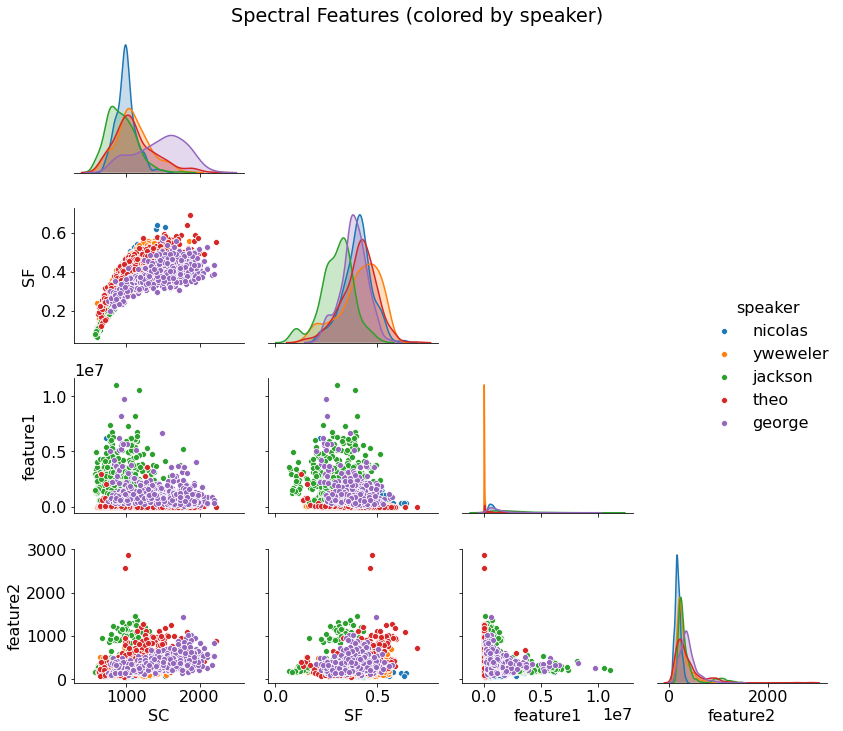

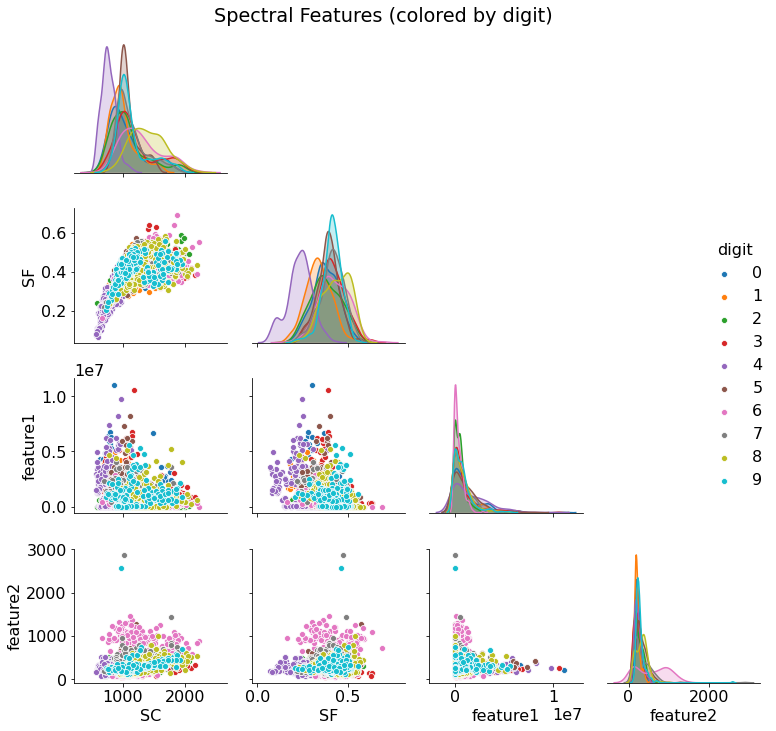

In [38]:
# Visualize a pairplot of the spectral features. In this instance, color each
# datapoint by the *person* speaking the digit to see if each *speaker* has a
# distinguishable set of spectral characteristics (e.g., deep vs high voice)
g = sns.pairplot(data=df, vars=['SC', 'SF', 'feature1', 'feature2'],
                 hue='speaker', corner=True)
plt.suptitle('Spectral Features (colored by speaker)', x=0.5, y=1.02)

# Clean up the plot appearance
plt.gcf().tight_layout()

# Repeat this plot, but now color each datapoint by the *digit* being spoken to
# see if each *word* has a distinguishable set of spectral characteristics
# (e.g., does the buzzing 'z' in 'zero' cause a different set of characteristics
# than the shap 't' sound in 'two'?)
g = sns.pairplot(data=df, vars=['SC', 'SF', 'feature1', 'feature2'],
                 hue='digit', corner=True)
plt.suptitle('Spectral Features (colored by digit)', x=0.5, y=1.02)

# Clean up the plot appearance
plt.gcf().tight_layout()

## Problem 3

Does it look like you have engineered some features that help separate the audio files by which digit was being spoken? What about by which person was speaking?

It's tough to say with so many overlapping points. Though it seems for a few plots, there seems to be some rough divisions for some of the features (SC vs. feature 2 [ZCR]).  

For digits, feature1 X SC or feature1 X SF seem to be OK classifiers.

You can re-jigger your feature extractors however you want (or add more), and re-run the above cells to examine those effects on the feature space.

# Train Machine Learning Algorithm

The following section perfectly parallels the content from the tutorial. We are simply copying it over here to the exercises so that you can see if your features helped classify the audio data.

You are not *quite* done yet though. There are some thoughts in the "Conclusion" section you may want to consider.

In [44]:
# Select the name of the column to be used as the desired 'label' output
# (For these files, it makes sense to use either 'speaker' or 'digit')
label = 'speaker'

# Create a list of features to be used in the classification process.
# We use the 'set' object in Python to quickly remove the unwanted columns
#
# NOTE: Add any columns you *do not* want to be included in the training
# algorithm to the "columns_to_remove" variable.
columns_to_remove = set([label, 'file', 'trial', 'ZCR', 'SFlux'])
features = set(df.columns) - columns_to_remove
features = list(features)

print('Classifying {} using...'.format(label))
print('features: {}'.format(features))

Classifying speaker using...
features: ['SF', 'digit', 'SC', 'feature1', 'feature2']


In [45]:
# Convert the data in the 'speaker', 'digit', and 'trial' columns of the
# dataframe into the 'Categorical' type.
df.speaker = pd.Categorical(df.speaker)
df.digit = pd.Categorical(df.digit)

In [46]:
# If the speaker is in the set of features used to classify the audio files,
# then the string speaker value should be converted to its numerical version.
if 'speaker' in features:
    # Add a column containing the numerically encoded version of speaker name
    df['speaker_code'] = df.speaker.cat.codes

    # Replace the 'speaker' feature with the 'speaker_code' feature
    features.remove('speaker')
    features.append('speaker_code')

    # Double check that there are not duplicate entries in the list of features
    # by converting to a `set` object (which automatically removes duplicate
    # entries) then convert back `list` object.
    features = list(set(features))

# Update the user on what columns and content remain in the datafram
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   digit     2500 non-null   category
 1   speaker   2500 non-null   category
 2   SC        2500 non-null   float64 
 3   SF        2500 non-null   float64 
 4   SFlux     0 non-null      float64 
 5   ZCR       0 non-null      float64 
 6   feature1  2500 non-null   float64 
 7   feature2  2500 non-null   float64 
dtypes: category(2), float64(6)
memory usage: 122.8 KB


Next we split the data into training and test sets.

In [47]:
# split X and y into training and testing sets
# NOTE: Using convention that X = features, y = label
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,features], df[label], test_size=0.25,
    random_state=0, stratify = df[label])

Now, with the correct training features and labels, we can train a machine learning classification model. To start with, let's consider a decision tree.

In [48]:
# Instantiate a DecisionTree model
model = tree.DecisionTreeClassifier(max_depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

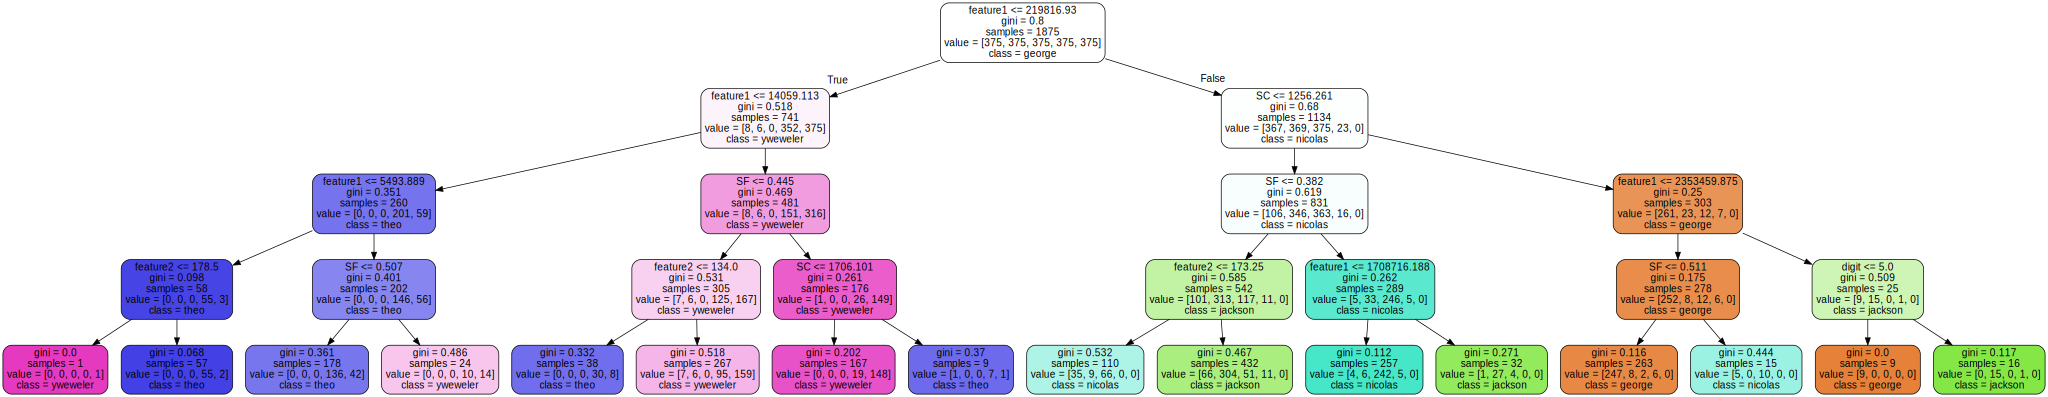

In [49]:
# Convert each class name into a string representation
class_names = [str(c) for c in model.classes_]

# Generate the data to visualize the decision tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=features,  
                         class_names=class_names,  
                         filled=True, rounded=True) 

# Visualize the tree from that exported data
graph = graphviz.Source(dot_data)  
graph

## Evaluate on Test Data

In [50]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
    """
    Plot the confusion matrix for the classifier

    :param cm: the actual confusion matrix
    :param labels: the labels to add along the axes of the matrix
    :param title: the title to place over the confusion matrix plot
    """
    # Generate a new figure and axes instance
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Display the confusion matrix (attempt to account for normalization)
    row_totals = np.sum(cm, axis=1)
    vmax_val = row_totals.max() if row_totals.max() > 1 else 1.0
    ax_im = ax.imshow(cm, cmap='Reds', vmin=0, vmax=vmax_val)

    # Annotate the figure
    plt.title(title, fontsize=20)
    fig.colorbar(ax_im)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=16, rotation=70)
    ax.set_yticklabels(labels, fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.show()

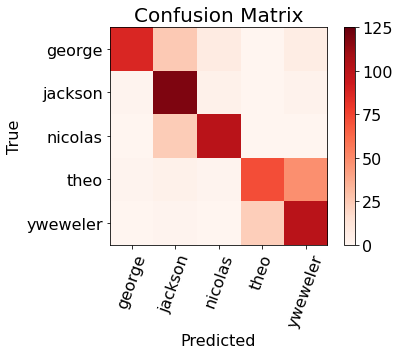

In [51]:
# Predict class label probabilities
labels=np.sort(y_test.unique())
y_test_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_test,y_test_pred, labels)
plot_cmatrix(cm, labels)

# Conclusion

For consistency with the tutorial, we have used a decision tree to classify the data, but you could train a *different* classifier. In particular, do you recall if there is a classifier that may help separate features that are all mingled together like some of these features are?